In [75]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score
import catboost
import re
import sys
sys.path.append('.')
from catboost import Pool
from src.utils import collect_data
collect_datasets = collect_data.DataCollection()
import shap

In [2]:
df_mobility_rm = collect_datasets.get_mobility_data(rolling_mean=True)
df_covid = collect_datasets.combine_covid_data()
df_county_demo = collect_datasets.combined_county_data()

In [3]:
county_dict = df_county_demo.set_index('fips')['COUNTY'].to_dict()
state_dict = df_county_demo.set_index('fips')['STATE'].to_dict()
def get_name(name_dict, x):
    
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['STATE'] = df_mobility_rm['fips'].apply(lambda x: get_name(state_dict, x))
df_mobility_rm['COUNTY'] = df_mobility_rm['fips'].apply(lambda x: get_name(county_dict, x))

# Mobility Reduction

In [4]:
df_mob_rm_train = df_mobility_rm.copy()

In [9]:
# Creating a dataframe to record reduction in mobility before and after covid
target_cols = ['m50'] #,'spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')

df_post_covid= df_mob_rm_train[df_mob_rm_train.date>=covid_date]
df_pre = df_mob_rm_train[(df_mob_rm_train.date<covid_date)]

df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()
pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_post_covid.groupby(['fips','date'])[target_cols].mean()

post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = df_covid_mean.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_m50']>=-0.5]
df_mob_spend_red.sample(5)

,fips,m50,Min_m50,min_date_m50,Drop_days_m50,Norm_Drop_Rate_m50,Pct_Red_m50
552,17075,16.129504,3.242429,2020-04-01,17,0.046999,0.798975
2053,47021,16.828018,5.106429,2020-04-06,22,0.031661,0.696552
122,05071,9.896946,4.569857,2020-04-17,33,0.016311,0.538256
84,04019,6.248842,0.352571,2020-04-07,23,0.041025,0.943578
1617,37015,11.799093,4.950000,2020-04-29,45,0.012899,0.580476


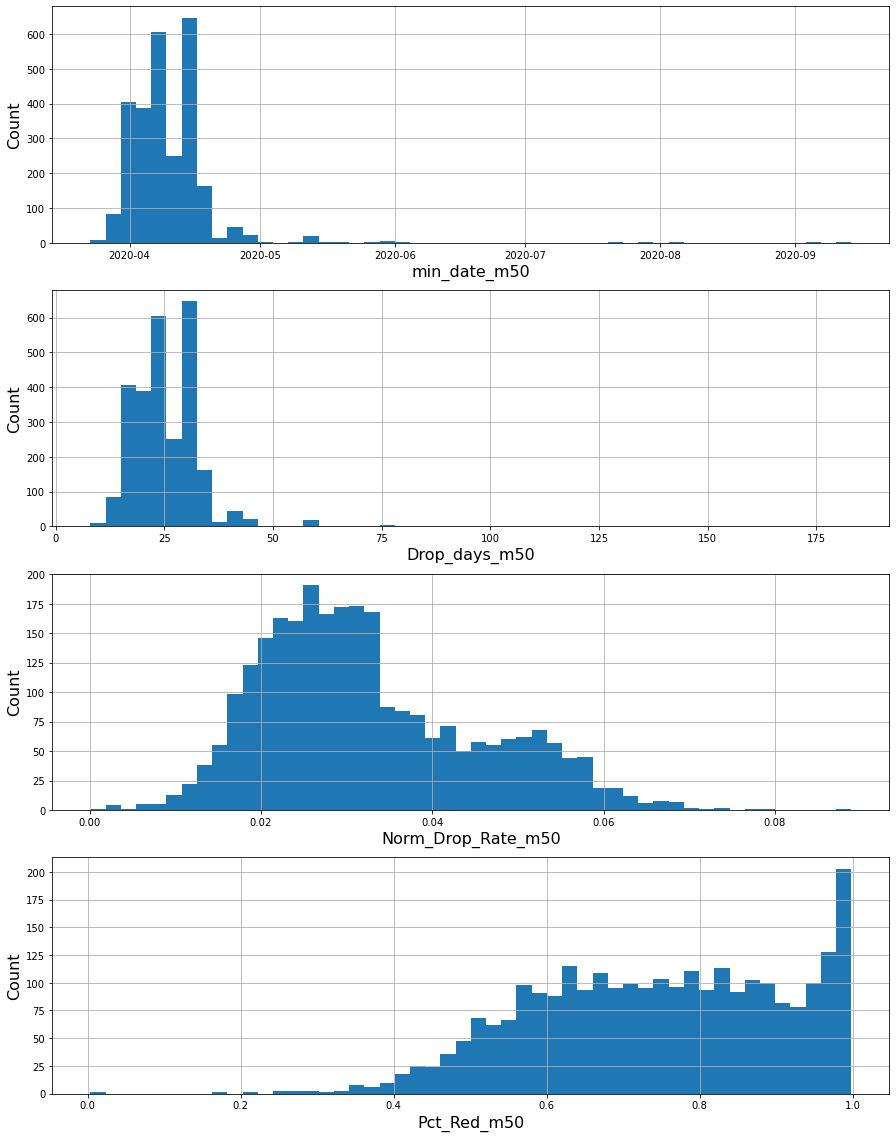

In [13]:
target_cols = df_mob_spend_red.columns[-4:]
f, axes = plt.subplots(4, 1,figsize=(15,20), sharex=False)
for ax,col in zip(axes.flatten(),target_cols):
    df_mob_spend_red[col].hist(bins=50,ax=ax)
    ax.set_xlabel(col ,fontsize=16)
    ax.set_ylabel('Count',fontsize=16)
        

In [56]:
df_covid_case_mean = pd.DataFrame(columns=['fips','mean_case_rate' ])
df_covid_death_mean = pd.DataFrame(columns=['fips','mean_death_rate' ])
df_covid_tr = df_covid[df_covid.date >=covid_date]
for fips in df_mob_spend_red.fips.unique():
    date_thr = df_mob_spend_red[df_mob_spend_red.fips==fips]['min_date_m50'].values[0]
    mean_case_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_cases'].mean()
    mean_death_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_deaths'].mean()
    df_covid_case_mean = df_covid_case_mean.append({'fips':fips,'mean_case_rate':mean_case_rate},ignore_index=True)
    df_covid_death_mean = df_covid_death_mean.append({'fips':fips,'mean_death_rate':mean_death_rate},ignore_index=True)

df_covid_death_mean

,fips,mean_death_rate
0,01001,0.037037
1,01003,0.034483
2,01005,0.000000
3,01007,0.000000
4,01009,0.000000
...,...,...
2661,56033,0.000000
2662,56035,0.000000
2663,56037,0.000000
2664,56039,0.000000


In [57]:
sheet_list = ['State of Emergency','Physical Distance Closures','Stay at Home',
              'Unemployment Insurance','Housing','Quarantine Rules','Food Security']

In [58]:
def get_model_df(df_mob_spend_red,df_covid_case_mean,df_covid_death_mean,df_county_demo,sheet_list):
    df_model = df_mob_spend_red.join(df_covid_case_mean.set_index('fips'), on='fips')
    df_model = df_model.join(df_covid_death_mean.set_index('fips'), on='fips')

    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    df_CUSP = pd.DataFrame()
    for sheet in sheet_list:
        df_CUSP_sheet = collect_datasets.load_CUSP(sheet)
        if len(df_CUSP)!=0:
            df_CUSP = df_CUSP.join(df_CUSP_sheet.set_index('STATE'), on='STATE')
        else:
            df_CUSP = df_CUSP_sheet.copy()
            
    df_model = df_model.join(df_CUSP.set_index('STATE'), on='STATE')
    df_atlas = collect_datasets.load_Atlas()
    df_model = df_model.join(df_atlas.set_index('FIPS'),on='fips')

    return df_model

In [59]:
df_model = get_model_df(df_mob_spend_red,df_covid_case_mean,df_covid_death_mean,df_county_demo,sheet_list)
df_model

,fips,m50,Min_m50,min_date_m50,Drop_days_m50,Norm_Drop_Rate_m50,Pct_Red_m50,mean_case_rate,mean_death_rate,YEAR,...,PctVetsDisabilty,PctNonVetsDisabilty,CivPopVets18to64Num,CivPop18ONum,Vets18ONum,NonVetsDisabilty,NonVetsPoor,VetsDisabilty,VetsPoor,CLFVets18to64Num
0,01001,12.671049,4.551286,2020-04-10,26,0.024647,0.640812,0.629630,0.037037,2014-2018,...,18.956229,15.927258,2533.0,41284.0,5071.0,4782.0,4562.0,563.0,142.0,2995.0
1,01003,11.438439,4.432000,2020-04-12,28,0.021876,0.612535,2.448276,0.034483,2014-2018,...,17.109763,10.749077,7058.0,162122.0,19354.0,11873.0,11795.0,1551.0,635.0,9172.0
2,01005,9.235674,4.576286,2020-04-17,33,0.015288,0.504499,0.441176,0.000000,2014-2018,...,38.164251,17.903577,359.0,20346.0,1561.0,2217.0,3225.0,237.0,79.0,732.0
3,01007,22.636673,8.262571,2020-04-12,28,0.022678,0.634992,0.551724,0.000000,2014-2018,...,28.839590,14.029267,345.0,17868.0,1278.0,1649.0,1595.0,169.0,50.0,635.0
4,01009,21.378212,9.241143,2020-04-12,28,0.020276,0.567731,0.448276,0.000000,2014-2018,...,26.007109,11.575693,1041.0,44126.0,3765.0,3707.0,4218.0,439.0,121.0,1688.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,56033,3.069907,1.506571,2020-04-15,31,0.016427,0.509245,0.343750,0.000000,2014-2018,...,12.800000,9.907278,947.0,23437.0,2681.0,1560.0,1014.0,160.0,62.0,1276.0
2663,56035,3.836421,0.464857,2020-04-06,22,0.039947,0.878831,0.043478,0.000000,2014-2018,...,0.000000,11.848426,216.0,7523.0,711.0,666.0,487.0,0.0,0.0,216.0
2664,56037,3.457919,2.241571,2020-04-16,32,0.010992,0.351757,0.303030,0.000000,2014-2018,...,12.079511,11.914236,1178.0,32302.0,2667.0,3084.0,2939.0,158.0,109.0,1320.0
2665,56039,7.329918,0.656000,2020-04-06,22,0.041387,0.910504,1.739130,0.000000,2014-2018,...,27.105263,6.783036,296.0,18625.0,984.0,1022.0,1276.0,103.0,13.0,380.0


In [60]:
df_model.corr()['Pct_Red_m50'][abs(df_model.corr()['Pct_Red_m50'])>0.4]

Min_m50                                                                                                                                                     -0.705472
Norm_Drop_Rate_m50                                                                                                                                           0.637948
Pct_Red_m50                                                                                                                                                  1.000000
Per Capita Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)    0.433654
pct_republican                                                                                                                                              -0.412830
Days_Closed non-essential businesses                                                                                                                        -0.447139
Days

In [78]:
def run_model(df,df_source,name,task_type='GPU',max_depth= 6,plot_shap=False):
    
    target_var = ['Pct_Red_m50']
    keep_cols = ['Pct_Red_m50', 'm50']
    remove_cols = ['fips', 'YEAR','COUNTY','NAME_E','STATE' ] + [col for col in df_source.columns if col not in keep_cols]
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("party")]
    
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=500, eval_metric='R2',
                                      max_depth=max_depth,devices='0',learning_rate=0.15,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    if plot_shap:
        shap_values_ks = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_index),
        type="ShapValues")
        shap_values_ks = shap_values_ks[:, :-1]

        shap.summary_plot(shap_values_ks, X_test)
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,X_test,y_test,y_pred_cb,cb_model


0:	learn: 0.1106658	total: 24.2ms	remaining: 12.1s
200:	learn: 0.9759976	total: 3.98s	remaining: 5.92s
400:	learn: 0.9975418	total: 8s	remaining: 1.98s
499:	learn: 0.9991238	total: 10s	remaining: 0us
0.66


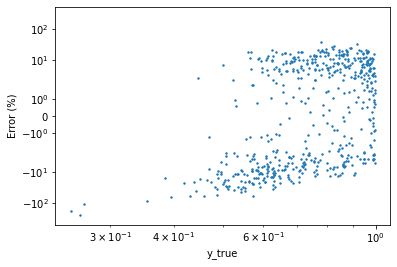

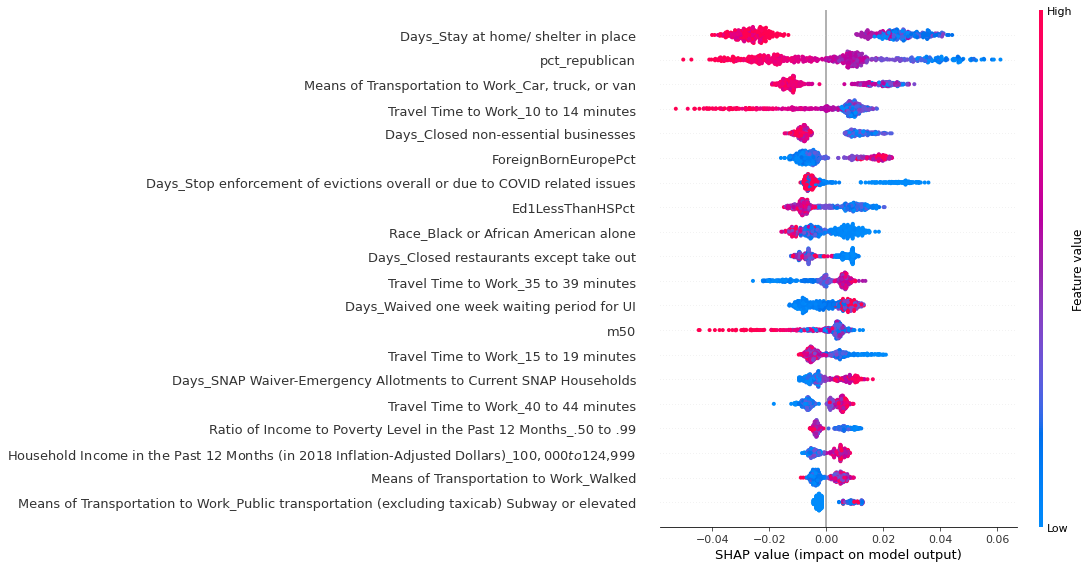

,Pre_Covid_Feature_Importance
Days_Stay at home/ shelter in place,8.225678
pct_republican,4.803473
Travel Time to Work_10 to 14 minutes,2.896395
Days_Closed non-essential businesses,2.821122
"Means of Transportation to Work_Car, truck, or van",2.809995
ForeignBornEuropePct,2.232700
Race_Black or African American alone,2.159565
Days_Closed restaurants except take out,1.801014
Ed1LessThanHSPct,1.791322
Days_Waived one week waiting period for UI,1.726177


In [79]:
df_model_fi,X_test,y_test,y_pred_cb,model = run_model(df_model,df_mob_spend_red,name = 'Pre', task_type='CPU',max_depth = 6,plot_shap=True)
df_model_fi.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 532 ||| Records with over 200% error 1


,error_pct,Count
STATE,,
South Dakota,-23.584942,3
Colorado,-20.626511,14
West Virginia,-13.162042,6
Oregon,-11.663821,5
Hawaii,-10.383063,3
Georgia,-9.370717,32
New Mexico,-8.606833,4
Florida,-6.672282,11
Tennessee,-6.148843,17


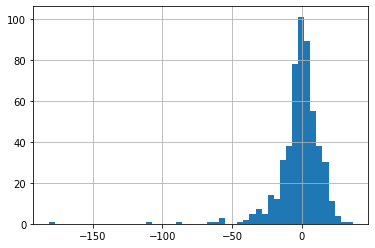

In [69]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test.Pct_Red_m50 - y_test.pred)*100/y_test.Pct_Red_m50
test_data = df_model.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=50)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].mean(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')